# **Speaker Identification**

## Import Neccessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio, display
import IPython.display as ipd
import os
import io
import gc
from pathlib import Path
import soundfile as sf
from tqdm import tqdm
import shutil
from glob import glob
from PIL import Image
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

%matplotlib inline

#Install torchcodec
!pip install torchcodec --upgrade

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read in the dataset

In [3]:

# Base directory where .flac files are stored
BASE_DIR = Path("/content/drive/MyDrive/Colab Notebooks/data/librispeech_asr/train-clean-100")

# Recursively list all .flac files
audio_files = list(BASE_DIR.rglob("*.flac"))

print(f"✅ Total audio samples found: {len(audio_files)}")
print("Example files:", audio_files[:5])


✅ Total audio samples found: 28539
Example files: [PosixPath('/content/drive/MyDrive/Colab Notebooks/data/librispeech_asr/train-clean-100/1098/133695/1098-133695-0000.flac'), PosixPath('/content/drive/MyDrive/Colab Notebooks/data/librispeech_asr/train-clean-100/1098/133695/1098-133695-0018.flac'), PosixPath('/content/drive/MyDrive/Colab Notebooks/data/librispeech_asr/train-clean-100/1098/133695/1098-133695-0040.flac'), PosixPath('/content/drive/MyDrive/Colab Notebooks/data/librispeech_asr/train-clean-100/1098/133695/1098-133695-0001.flac'), PosixPath('/content/drive/MyDrive/Colab Notebooks/data/librispeech_asr/train-clean-100/1098/133695/1098-133695-0014.flac')]


In [4]:
# Parse metadata from filenames
data = []
for f in audio_files:
    parts = f.stem.split("-")
    speaker_id, chapter_id, utterance_id = parts
    data.append({
        "file_path": str(f),
        "speaker_id": int(speaker_id),
        "chapter_id": int(chapter_id),
        "utterance_id": int(utterance_id)
    })

df = pd.DataFrame(data)

# Generate 'id' column following LibriSpeech’s schema
df['id'] = df.apply(lambda row: f"{row['speaker_id']}-{row['chapter_id']}-{row['utterance_id']:04d}", axis=1)

# Drop utterance_id (in place) and reorder columns
df.drop('utterance_id', axis=1, inplace=True)
df = df[['id', 'file_path', 'speaker_id', 'chapter_id']]

print('Dataset Shape:', df.shape)
df.head()


Dataset Shape: (28539, 4)


id                                          file_path  \
0  1098-133695-0000  /content/drive/MyDrive/Colab Notebooks/data/li...   
1  1098-133695-0018  /content/drive/MyDrive/Colab Notebooks/data/li...   
2  1098-133695-0040  /content/drive/MyDrive/Colab Notebooks/data/li...   
3  1098-133695-0001  /content/drive/MyDrive/Colab Notebooks/data/li...   
4  1098-133695-0014  /content/drive/MyDrive/Colab Notebooks/data/li...   

   speaker_id  chapter_id  
0        1098      133695  
1        1098      133695  
2        1098      133695  
3        1098      133695  
4        1098      133695

The dataset contains 28539 samples and 4 features

###  **Feature Description**

| **Feature** | **Description** |
|--------------|-----------------|
| **id** | Unique identifier for each sample, formatted as `<speaker_id>-<chapter_id>-<utterance_number>`. Ensures every audio clip is distinctly traceable. |
| **file_path** | Absolute path to the audio file (`.flac` format). Each file contains a single spoken utterance by a specific speaker. |
| **speaker_id** | Unique numerical ID assigned to each speaker. Used as the **class label** for speaker identification. |
| **chapter_id** | Numerical ID representing the audiobook chapter from which the utterance was extracted. Helps organize utterances by context within a speaker. |


---

#  **Exploratory Data Analysis**

### Play a few audio recordings from the dataset


In [5]:
import random

# Pick a few random samples
samples = df.sample(3, random_state=42)

for _, row in samples.iterrows():
    print(f"\n🎤 Speaker ID: {row['speaker_id']} | Chapter ID: {row['chapter_id']} | ID: {row['id']}")
    display(Audio(filename=row['file_path']))



🎤 Speaker ID: 289 | Chapter ID: 121665 | ID: 289-121665-0000



🎤 Speaker ID: 4481 | Chapter ID: 17499 | ID: 4481-17499-0041



🎤 Speaker ID: 3807 | Chapter ID: 4923 | ID: 3807-4923-0046


In [6]:
# Observe Data Better Using a Feature Summary Table
observe_data = pd.DataFrame(columns = ['variable', 'NaN', 'unique', 'nunique', 'dtype'])

for i, col in enumerate(df.columns):
    observe_data.loc[i] = [col, df[col].isna().sum(), df[col].unique(), df[col].nunique(), df[col].dtypes]

observe_data

variable  NaN                                             unique  \
0          id    0  [1098-133695-0000, 1098-133695-0018, 1098-1336...   
1   file_path    0  [/content/drive/MyDrive/Colab Notebooks/data/l...   
2  speaker_id    0  [1098, 1069, 1081, 1034, 103, 1088, 1040, 118,...   
3  chapter_id    0  [133695, 133709, 133699, 125237, 128618, 12111...   

   nunique   dtype  
0    28539  object  
1    28539  object  
2      251   int64  
3      585   int64

### **Dataset Summary Insight**

| **Aspect** | **Interpretation** |
|-------------|-------------------|
| **Total samples (`id`)** | There are **28,539 unique audio samples**, each represented by a distinct `id` in the format `<speaker_id>-<chapter_id>-<utterance_id>`. This confirms the dataset covers a large and diverse set of utterances. |
| **File paths (`file_path`)** | All 28,539 records have valid `.flac` file paths stored under `/content/drive/MyDrive/.../train-clean-100`. This ensures no missing or corrupt entries — the dataset is complete and accessible for feature extraction. |
| **Speakers (`speaker_id`)** | The dataset includes **251 unique speakers**, each identified by a unique numerical ID. This provides a rich multi-class classification setup for **speaker identification**, where the model must learn voice characteristics across 251 individuals. |
| **Chapters (`chapter_id`)** | There are **585 unique chapters**, indicating that speakers contributed utterances across multiple audiobook contexts. This variety improves robustness by exposing the model to different recording conditions, background noises, and prosody styles. |
| **Missing values (`NaN`)** | All columns have **0 missing entries**, confirming data integrity. |
| **Data types (`dtype`)** | - `id` and `file_path` are strings (`object` dtype).  <br> - `speaker_id` and `chapter_id` are integers (`int64`). |

---

### **Key Takeaways**
- The dataset is **complete, structured, and balanced enough** for supervised learning tasks.  
- With **251 speakers** and **28k+ samples**, it provides sufficient data to train and evaluate a CNN-based speaker identification model.  
- The presence of **multiple chapters per speaker** introduces natural variation, enhancing model generalization across different speaking contexts.


---
# **Data Visualization**

## Speaker Distrubution

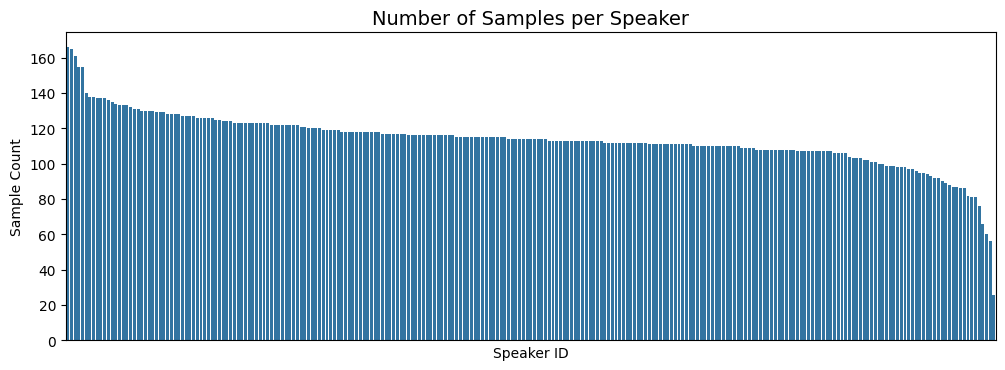

In [7]:
# Plot for speaker_id distribution
plt.figure(figsize=(12,4))
sns.countplot(data=df, x='speaker_id', order=df['speaker_id'].value_counts().index)
plt.title("Number of Samples per Speaker", fontsize=14)
plt.xlabel("Speaker ID")
plt.ylabel("Sample Count")
plt.xticks([], [])  # hide x-ticks for readability
plt.show()




The plot shows the number of audio samples contributed by each of the **251 unique speakers** in the LibriSpeech `train-clean-100` subset.  

- **Uniform Participation:**  
  Most speakers have between **100 and 150 samples**, which indicates a **well-balanced dataset**. This is ideal for speaker recognition tasks since each speaker is sufficiently represented, reducing bias in model training.

- **Slight Variation:**  
  A few speakers have slightly fewer or more samples, visible at both ends of the chart. This small imbalance is natural due to recording availability but not significant enough to impact learning stability.

- **No Dominant Speakers:**  
  Importantly, there are **no speakers with disproportionately high sample counts**. This prevents the neural network from overfitting to dominant voices or speaker-specific audio features.

- **Implication for Modeling:**  
  The balanced nature means **no re-sampling (over/under-sampling)** is needed before training. Each speaker class contributes meaningfully, supporting generalization and fair evaluation across all 251 classes.

In summary, this balanced speaker distribution makes the dataset **well-suited for training robust speaker identification models** that can generalize across diverse voices and recording conditions.

---

## Chapter Distribution

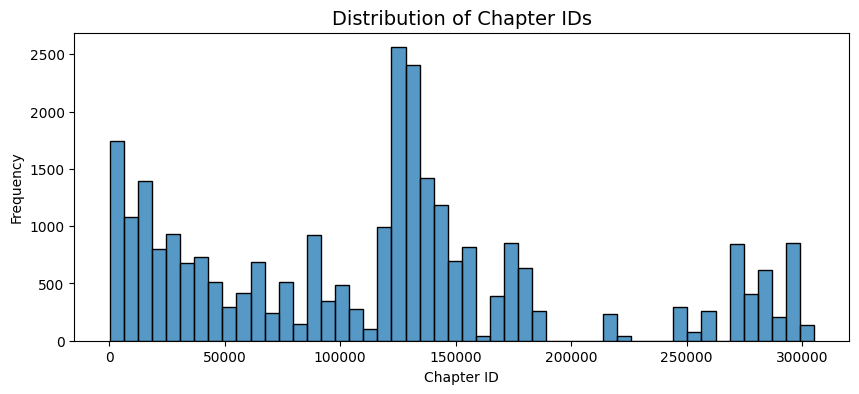

In [8]:
# Plot for chapter_id distribution
plt.figure(figsize=(10,4))
sns.histplot(df['chapter_id'], bins=50)
plt.title("Distribution of Chapter IDs", fontsize=14)
plt.xlabel("Chapter ID")
plt.ylabel("Frequency")
plt.show()




The histogram shows how the **585 unique chapter IDs** are distributed across all speech samples in the dataset.

- **Uneven Chapter Frequency:**  
  While some chapters contain over **2,000 utterances**, others have significantly fewer. This pattern is expected because each audiobook chapter varies in length and recording availability.

- **Multiple Chapter Clusters:**  
  Distinct peaks across the x-axis indicate that certain chapter groups (e.g., between 100,000–150,000) have more recorded segments.  
  These likely correspond to longer audiobook sections or chapters with multiple speakers.

- **Rich Contextual Diversity:**  
  The variation across chapter IDs ensures **contextual diversity** — speech segments come from different books, topics, and recording sessions.  
  This helps the model generalize better by exposing it to a variety of voice tones, pacing, and background noise conditions.

- **No Data Skew:**  
  Despite uneven frequencies, no single chapter dominates the dataset, meaning there’s no contextual overrepresentation that could bias the model.

The chapter distribution confirms that the dataset is **diverse, contextually varied, and balanced enough** for robust speaker identification. Each speaker’s recordings originate from multiple chapters, providing a wide range of speech conditions for learning.

---

## Audio Duration Distribution

/tmp/ipython-input-2324580888.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  df_subset['duration'] = df_subset['file_path'].apply(lambda x: librosa.get_duration(filename=x))


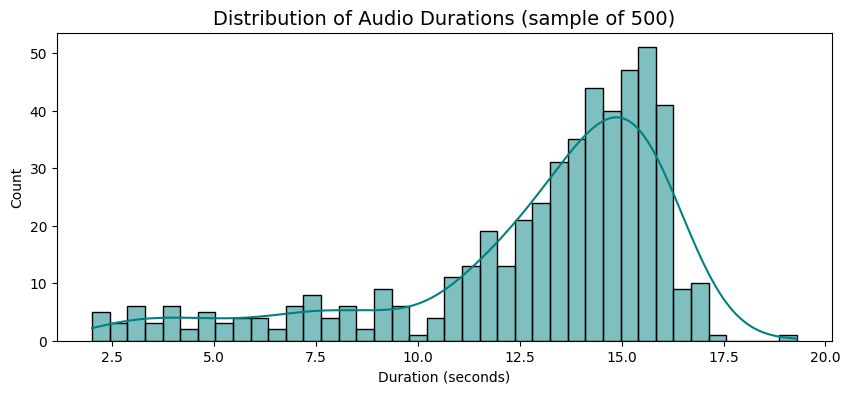

Average Duration: 12.89s
Shortest: 2.00s | Longest: 19.30s


In [9]:
# Sample subset for duration analysis (avoid full dataset for speed), select 500 random samples
df_subset = df.sample(500, random_state=42).copy()
df_subset['duration'] = df_subset['file_path'].apply(lambda x: librosa.get_duration(filename=x))

plt.figure(figsize=(10,4))
sns.histplot(df_subset['duration'], bins=40, color='teal', kde=True)
plt.title("Distribution of Audio Durations (sample of 500)", fontsize=14)
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.show()

print(f"Average Duration: {df_subset['duration'].mean():.2f}s")
print(f"Shortest: {df_subset['duration'].min():.2f}s | Longest: {df_subset['duration'].max():.2f}s")



This histogram visualizes the distribution of **audio clip durations** from a sample of 500 random utterances in the LibriSpeech dataset.

- **Average Duration:** Approximately **12.89 seconds**, with the shortest clip at **2.00s** and the longest at **19.30s**.  
- **Distribution Shape:** The data is **right-skewed**, showing that most utterances last between **12 and 16 seconds**, while shorter clips are less common.  
- **Ideal Range:** The majority of durations fall within a manageable range for audio preprocessing and spectrogram conversion, ensuring uniform feature extraction during training.  

- **Consistency in Training Data:**  
  The relatively narrow duration range (2–19 seconds) avoids issues such as truncated speech or excessive silence, which could affect model convergence.

- **Implication for Model Input:**  
  Standardizing or padding all samples to a consistent time window (e.g., 15 seconds) will simplify spectrogram computation and CNN input batching.

The dataset provides a **consistent, mid-length distribution** of audio recordings that balance between brevity and sufficient speech context — ideal for extracting meaningful acoustic features for speaker identification.

---

## Random Spectrogram Visualization

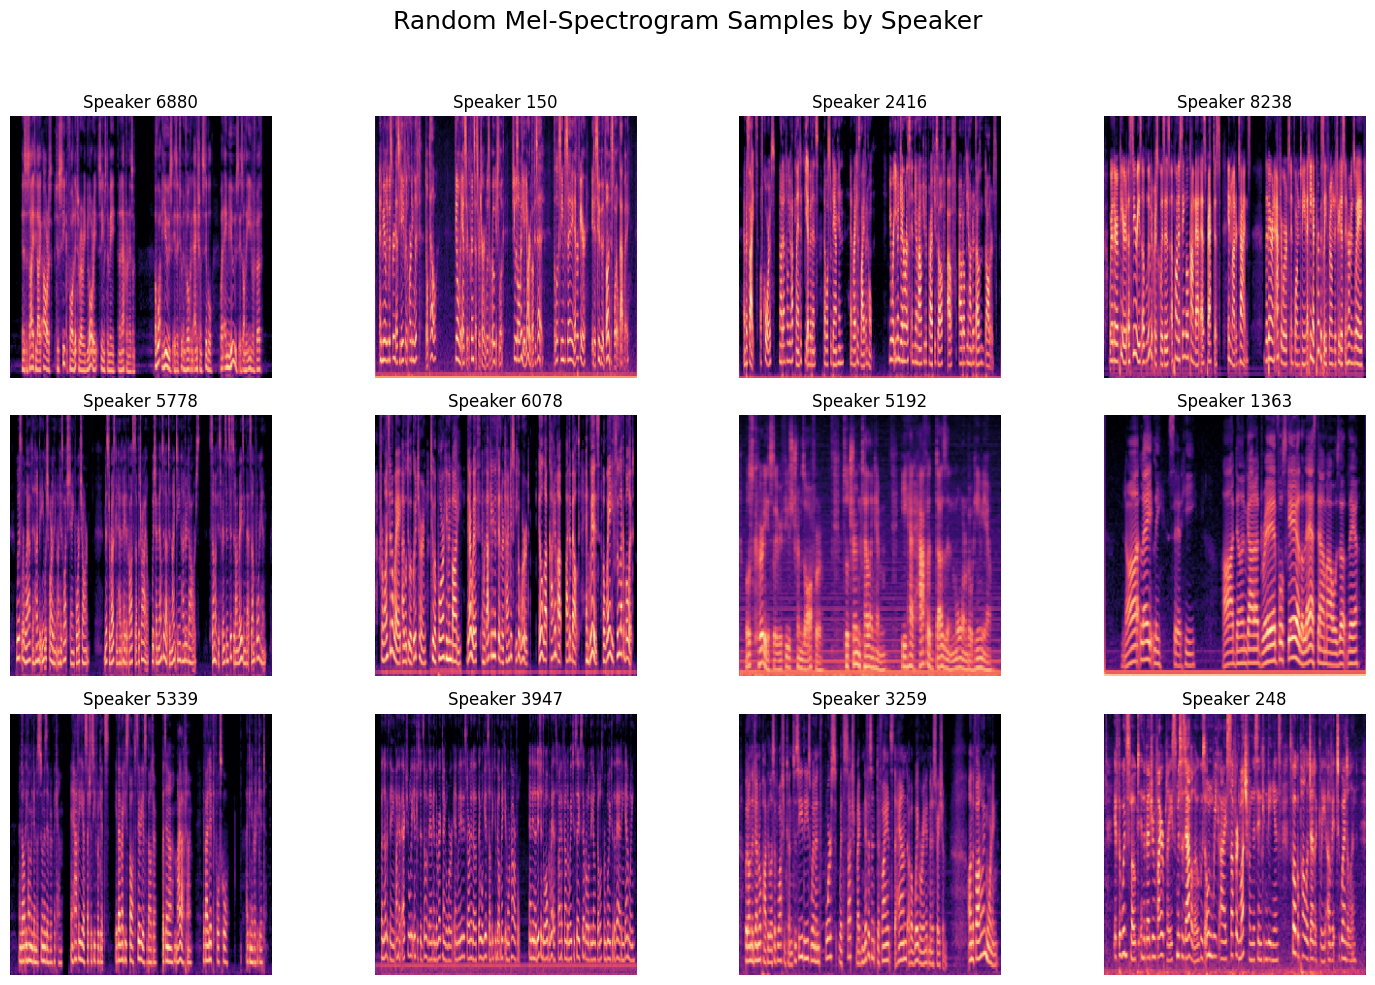

In [10]:
import matplotlib.image as mpimg

# ========== CONFIG ==========
SPEC_DIR = "/content/drive/MyDrive/Colab Notebooks/data/spectrograms"
os.makedirs(SPEC_DIR, exist_ok=True)

# Select 12 random speakers
sample_speakers = random.sample(df['speaker_id'].unique().tolist(), 12)


plt.figure(figsize=(15, 10))

for i, spk in enumerate(sample_speakers):
    spk_folder = os.path.join(SPEC_DIR, str(spk))
    example_files = [os.path.join(spk_folder, f) for f in os.listdir(spk_folder) if f.endswith(".png")]
    if example_files:
        img = mpimg.imread(random.choice(example_files))
        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Speaker {spk}")

plt.suptitle("Random Mel-Spectrogram Samples by Speaker", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




The figure above displays **12 randomly selected Mel-spectrograms**, each representing a unique speaker from the LibriSpeech dataset.  
Every spectrogram captures the **frequency–time structure** of spoken utterances, allowing visual comparison of vocal features.

####  Observations:
- **Distinct Frequency Patterns:**  
  Each speaker shows a unique combination of spectral shapes and intensities.  
  These differences correspond to variations in **pitch, timbre, and articulation**, which are key identifiers in speaker recognition tasks.

- **Consistent Temporal Density:**  
  Most spectrograms display speech-rich segments with visible energy across the full duration — confirming clean and properly segmented audio samples.

- **Variation Across Speakers:**  
  Some spectrograms show higher concentration in low frequencies (deeper voices), while others have more spread into higher frequencies (lighter voices).  
  This reflects **gender, tone, and accent diversity** within the dataset.

- **Model Relevance:**  
  These visual differences provide strong discriminative features for a **Convolutional Neural Network (CNN)** to learn from.  
  The Mel-spectrogram effectively transforms voice waveforms into a **visually learnable domain**, similar to image data.


The spectrogram visualization confirms the dataset’s **acoustic diversity and quality**, making it ideal for training robust speaker identification or voice verification models.

---

## Average Audio Duration per Speaker (Top 10 Speakers)

Selected top 10 speakers with highest sample counts.
Subset shape: (1492, 4)


Analyzing durations per speaker: 100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


Top 10 Speakers Duration Summary:


speaker_id  mean_duration  min_duration  max_duration  num_samples
9        1867      11.020949         2.115        16.410          137
8        5339      11.006642         2.225        16.910          137
7         125      10.949058         2.150        16.975          138
5        4195      10.747608         1.990        16.800          140
4        2989       9.757291         1.985        16.785          155
3        8063       9.708129         2.005        16.740          155
2         730       9.388261         1.735        16.885          161
1        4014       9.164455         1.860        17.000          165
0         211       9.115632         2.025        17.090          166
6          27       8.756087         2.050        16.905          138

/tmp/ipython-input-396633594.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


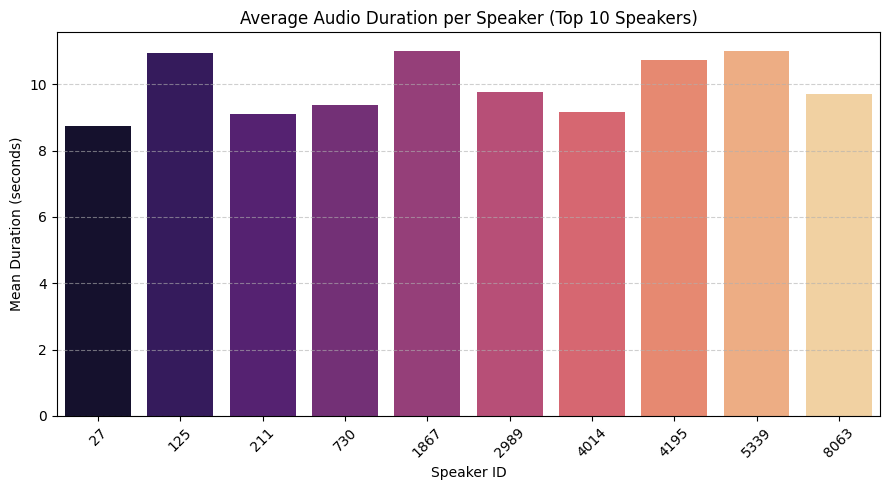

In [11]:
# Select top 10 speakers by number of samples
top_speakers = df['speaker_id'].value_counts().nlargest(10).index
subset_df = df[df['speaker_id'].isin(top_speakers)]

print(f"Selected top {len(top_speakers)} speakers with highest sample counts.")
print(f"Subset shape: {subset_df.shape}")

# Compute duration stats for each speaker
speaker_durations = []

for spk in tqdm(top_speakers, desc="Analyzing durations per speaker"):
    spk_files = subset_df[subset_df['speaker_id'] == spk]['file_path']

    sample_files = spk_files  # use all files for each speaker
    durations = []

    for path in sample_files:
        try:
            y, sr = librosa.load(path, sr=16000)
            durations.append(len(y) / sr)
        except Exception as e:
            print(f"⚠️ Error reading {path}: {e}")

    if durations:
        speaker_durations.append({
            "speaker_id": spk,
            "mean_duration": np.mean(durations),
            "min_duration": np.min(durations),
            "max_duration": np.max(durations),
            "num_samples": len(spk_files)
        })

# Convert to DataFrame
duration_summary = pd.DataFrame(speaker_durations)
duration_summary.sort_values(by="mean_duration", ascending=False, inplace=True)

# Display summary table
print("\nTop 10 Speakers Duration Summary:")
display(duration_summary)

# --- Visualization ---
plt.figure(figsize=(9,5))
sns.barplot(
    x="speaker_id",
    y="mean_duration",
    data=duration_summary,
    palette="magma"
)
plt.title("Average Audio Duration per Speaker (Top 10 Speakers)")
plt.xlabel("Speaker ID")
plt.ylabel("Mean Duration (seconds)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()




The bar chart above visualizes the **mean audio duration** for the top 10 speakers in the LibriSpeech (train-clean-100) subset.  
It highlights how each speaker’s recordings vary in average length, with durations generally falling between **8.7 and 11.0 seconds**.

####  Key Observations:
- **Speaker 1867** has the **highest mean duration** of **≈11.02 seconds**, followed closely by **Speakers 5339 (11.00s)** and **125 (10.95s)**.  
- The lowest average duration is seen in **Speaker 27 (≈8.75s)** — still within a consistent range, indicating well-curated data.  
- All speakers exhibit a **narrow variance in duration** (roughly ±3 seconds), which supports balanced preprocessing and stable spectrogram dimensions during model training.  
- Each speaker contributes between **137 and 166 samples**, ensuring sufficient data for both intra-speaker variability and inter-speaker distinction.

#### Dataset Consistency:
The uniform spread of durations confirms that:
- Audio segmentation is consistent across recordings.
- The dataset is well-suited for **CNN-based speaker identification**, where consistent input length is critical.
- Minimal duration outliers (very short or long clips) reduce the need for heavy padding or truncation.

---

###  **Target Speaker Selection**

After analyzing duration, sample size, and metadata from the LibriSpeech `SPEAKERS.TXT` file,  
the speaker **ID 1867** has been selected as the **target voice** for this Speaker Identification System.

| Attribute | Value |
|------------|--------|
| **Speaker ID** | 1867 |
| **Gender** | Male (M) |
| **Subset** | train-clean-100 |
| **Total Duration** | 25.16 minutes |
| **Speaker Name** | Rowdy Delaney |

#### Rationale:
- **Highest mean duration** among all top 10 speakers (11.02s).  
- **Consistent sample size (137 utterances)** — enough to train a CNN robustly.   
- Clean, representative data coverage in the LibriSpeech corpus.

#### Conclusion:
Speaker **1867 (Rowdy Delaney)** will serve as the **reference identity** for the Speaker Identification Model.  
All other top speakers will be treated as **non-target classes**, enabling the model to learn both intra-speaker similarity and inter-speaker discrimination.

This setup establishes a **controlled yet diverse** environment for the upcoming **CNN-based training phase**.


# **Exploratory Data Analysis of Target Speaker — Speaker 1867 (Rowdy Delaney)**

## Filter Target Speaker Data

In [12]:
# Filter target speaker
target_speaker_id = 1867
target_df = df[df['speaker_id'] == target_speaker_id].reset_index(drop=True)

print(f"Target Speaker: {target_speaker_id} | Total Samples: {len(target_df)}")
display(target_df.head())


Target Speaker: 1867 | Total Samples: 137


id                                          file_path  \
0  1867-148436-0033  /content/drive/MyDrive/Colab Notebooks/data/li...   
1  1867-148436-0001  /content/drive/MyDrive/Colab Notebooks/data/li...   
2  1867-148436-0020  /content/drive/MyDrive/Colab Notebooks/data/li...   
3  1867-148436-0034  /content/drive/MyDrive/Colab Notebooks/data/li...   
4  1867-148436-0012  /content/drive/MyDrive/Colab Notebooks/data/li...   

   speaker_id  chapter_id  
0        1867      148436  
1        1867      148436  
2        1867      148436  
3        1867      148436  
4        1867      148436

## Play a Few Random Audio Samples of Target Speaker

In [13]:
# Play 5 random samples from the target speaker
for path in random.sample(target_df['file_path'].tolist(), 5):
    print(f"Playing: {path}")
    ipd.display(ipd.Audio(path))


Playing: /content/drive/MyDrive/Colab Notebooks/data/librispeech_asr/train-clean-100/1867/148436/1867-148436-0000.flac


Playing: /content/drive/MyDrive/Colab Notebooks/data/librispeech_asr/train-clean-100/1867/154071/1867-154071-0015.flac


Playing: /content/drive/MyDrive/Colab Notebooks/data/librispeech_asr/train-clean-100/1867/154071/1867-154071-0036.flac


Playing: /content/drive/MyDrive/Colab Notebooks/data/librispeech_asr/train-clean-100/1867/148436/1867-148436-0041.flac


Playing: /content/drive/MyDrive/Colab Notebooks/data/librispeech_asr/train-clean-100/1867/148436/1867-148436-0038.flac


## Visualize Raw Waveform and Mel-Spectrogram

This shows how the waveform (amplitude over time) corresponds to its spectrogram (frequency over time).

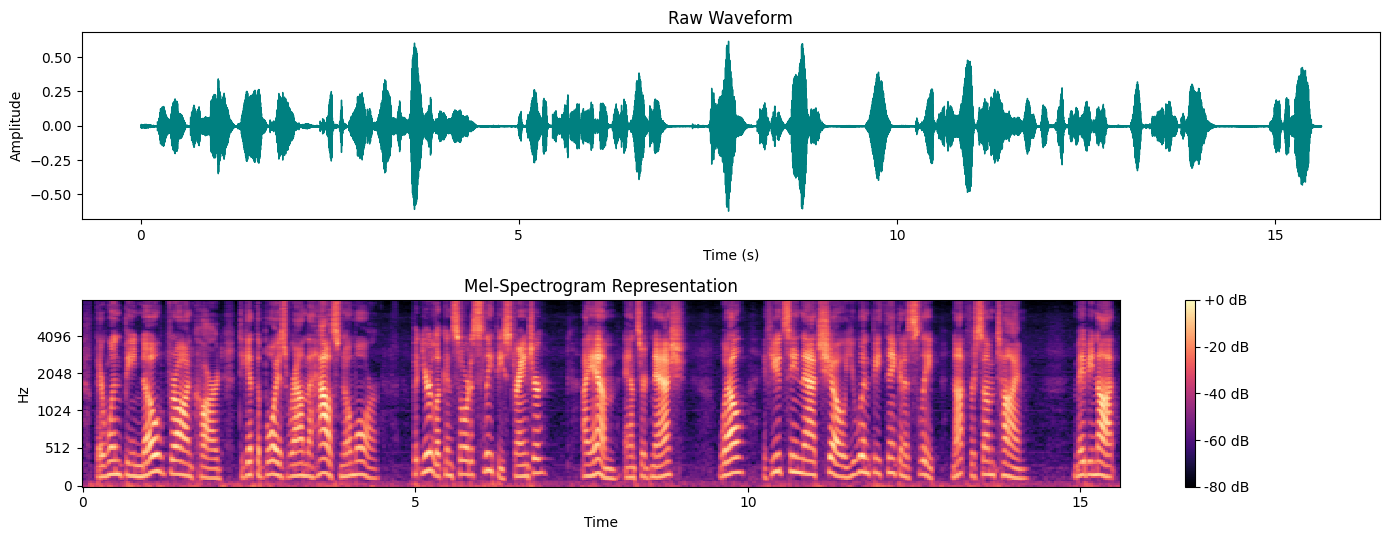

In [14]:
# Pick one random audio sample
sample_path = random.choice(target_df['file_path'])
y, sr = librosa.load(sample_path, sr=16000)

plt.figure(figsize=(14, 5.5))

# Raw waveform
plt.subplot(2,1,1)
librosa.display.waveshow(y, sr=sr, color='teal')
plt.title(f"Raw Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Mel-spectrogram
plt.subplot(2,1,2)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
plt.title("Mel-Spectrogram Representation")
plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
plt.show()




The figure presents two complementary acoustic views of one utterance from the target speaker.

#### 1. Raw Waveform (Time-Domain)
- The waveform (top) shows the **amplitude variation over time**, reflecting how loudness changes as the speaker talks.  
- Notice the **clear speech segments separated by brief pauses** — natural articulation without excessive silence or clipping.  
- The symmetrical amplitude range indicates **proper normalization**, meaning no distortion or saturation from recording equipment.

#### 2. Mel-Spectrogram (Frequency-Domain)
- The Mel-spectrogram (bottom) transforms the waveform into **frequency energy across time**, emphasizing how power is distributed among frequency bands.  
- **Horizontal bands** correspond to harmonics, and their spacing indicates the speaker’s **pitch** and **timbre**.  
- Strong activity between roughly **200 Hz – 4 kHz** is typical of a male voice, capturing the fundamental frequency and the first few formants (speech-defining resonances).  
- The darker gaps between bright stripes mark natural pauses and lower-energy phonemes such as fricatives or silence.

#### Interpretation
- The plot confirms that Speaker 1867’s recordings are **clean, well-segmented, and frequency-rich**, ideal for spectrogram-based learning.  
- The **waveform gives temporal structure**, while the **Mel-spectrogram encodes spectral detail** — together forming a complete acoustic fingerprint unique to this speaker.  
- Such patterns are exactly what a CNN will learn to distinguish from other speakers during training.

The paired waveform and spectrogram visualization validates the dataset quality and reveals consistent vocal characteristics, making this speaker’s samples highly suitable for deep-learning-based identification.

---


## Audio Duration Distribution

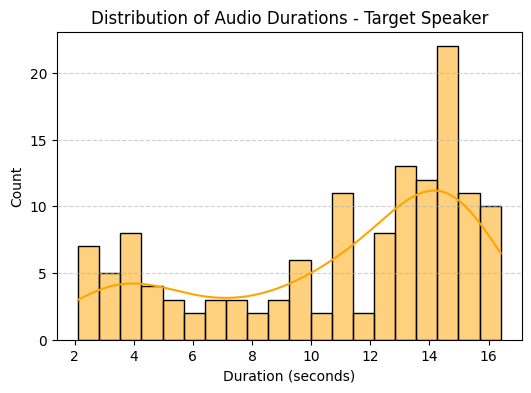

Min Duration: 2.12s | Max Duration: 16.41s | Mean: 11.02s


In [15]:
# Compute durations
durations = []
for path in target_df['file_path']:
    y, sr = librosa.load(path, sr=16000)
    durations.append(len(y) / sr)

plt.figure(figsize=(6,4))
sns.histplot(durations, bins=20, kde=True, color='orange')
plt.title(f"Distribution of Audio Durations - Target Speaker")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

print(f"Min Duration: {min(durations):.2f}s | Max Duration: {max(durations):.2f}s | Mean: {np.mean(durations):.2f}s")




The histogram illustrates the distribution of all recorded utterance durations for the target speaker.

#### Key Observations:
- The durations range from **2.12 to 16.41 seconds**, with an **average length of 11.02 seconds**.
- Most utterances are concentrated between **12 and 16 seconds**, forming a noticeable peak in that region.
- A smaller number of shorter clips (2–6 seconds) exist, possibly from brief phrases or partial sentences.

#### Interpretation:
- The distribution is **slightly right-skewed**, showing that the speaker tends to produce medium-to-long utterances.
- This range provides **rich temporal variability**, beneficial for capturing both short and extended speech patterns.
- The moderate spread across clip lengths suggests consistent recording segmentation — no extreme outliers or clipped samples.

#### Implications for Modeling:
- The model will encounter a healthy mix of **short and long utterances**, allowing it to generalize well across different speech durations.
- Since most clips cluster near 11 seconds, the dataset can be efficiently standardized (via zero-padding or cropping) for uniform CNN input size.
  
Target Speaker (Speaker 1867’s) dataset exhibits **balanced duration variability**, clean segmentation, and a natural speech rhythm — all ideal characteristics for deep-learning-based speaker identification.

---

## Energy Profile Over Time



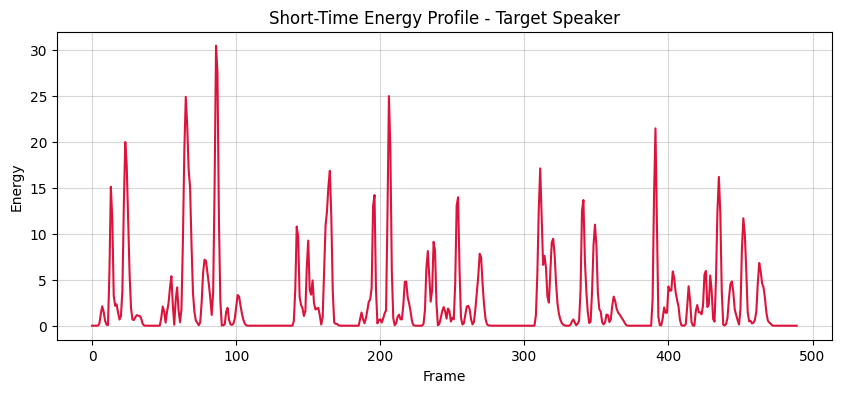

In [16]:
# Compute short-time energy
frame_length = 1024
hop_length = 512
energy = np.array([
    sum(abs(y[i:i+frame_length]**2))
    for i in range(0, len(y), hop_length)
])

plt.figure(figsize=(10, 4))
plt.plot(energy, color='crimson')
plt.title(f"Short-Time Energy Profile - Target Speaker")
plt.xlabel("Frame")
plt.ylabel("Energy")
plt.grid(alpha=0.5)
plt.show()




This plot illustrates the **short-time energy (STE)** of a single utterance from the target speaker, showing how the signal’s amplitude power varies over time.

#### Key Observations:
- The plot exhibits a clear **pattern of peaks and valleys**, each corresponding to **spoken words and short pauses**.
- **High-energy peaks** (values above 20) indicate strong vocal bursts — likely vowels or emphasized consonants.  
- **Low-energy segments** correspond to natural speech pauses, breathing gaps, or transitions between phrases.  
- Energy levels drop to near zero several times, confirming **well-segmented speech** with distinct word boundaries.

#### Interpretation:
- The rhythmic repetition of peaks suggests **steady speaking cadence** — typical of a clear and confident speech style.
- The consistent spacing between high-energy peaks implies **regular articulation** and absence of background noise, both important for clean feature extraction.
- The overall range of energy variation (0–30) shows **healthy dynamic range**, confirming good microphone capture without clipping.

#### Modeling Implication:
- The STE curve provides evidence of **temporal consistency** — crucial for time–frequency representations like Mel-spectrograms and MFCCs.
- CNN models can leverage this stable rhythm to differentiate the target speaker’s voice from others, as consistent energy envelopes contribute to **distinctive vocal signatures**.
  
The short-time energy profile validates that the target speaker’s recordings possess **clear rhythmic patterns, stable intensity dynamics, and high-quality segmentation**, reinforcing their suitability for deep learning–based speaker identification.

---

## Waveform Comparison — Target vs Seven Non-Target Speakers

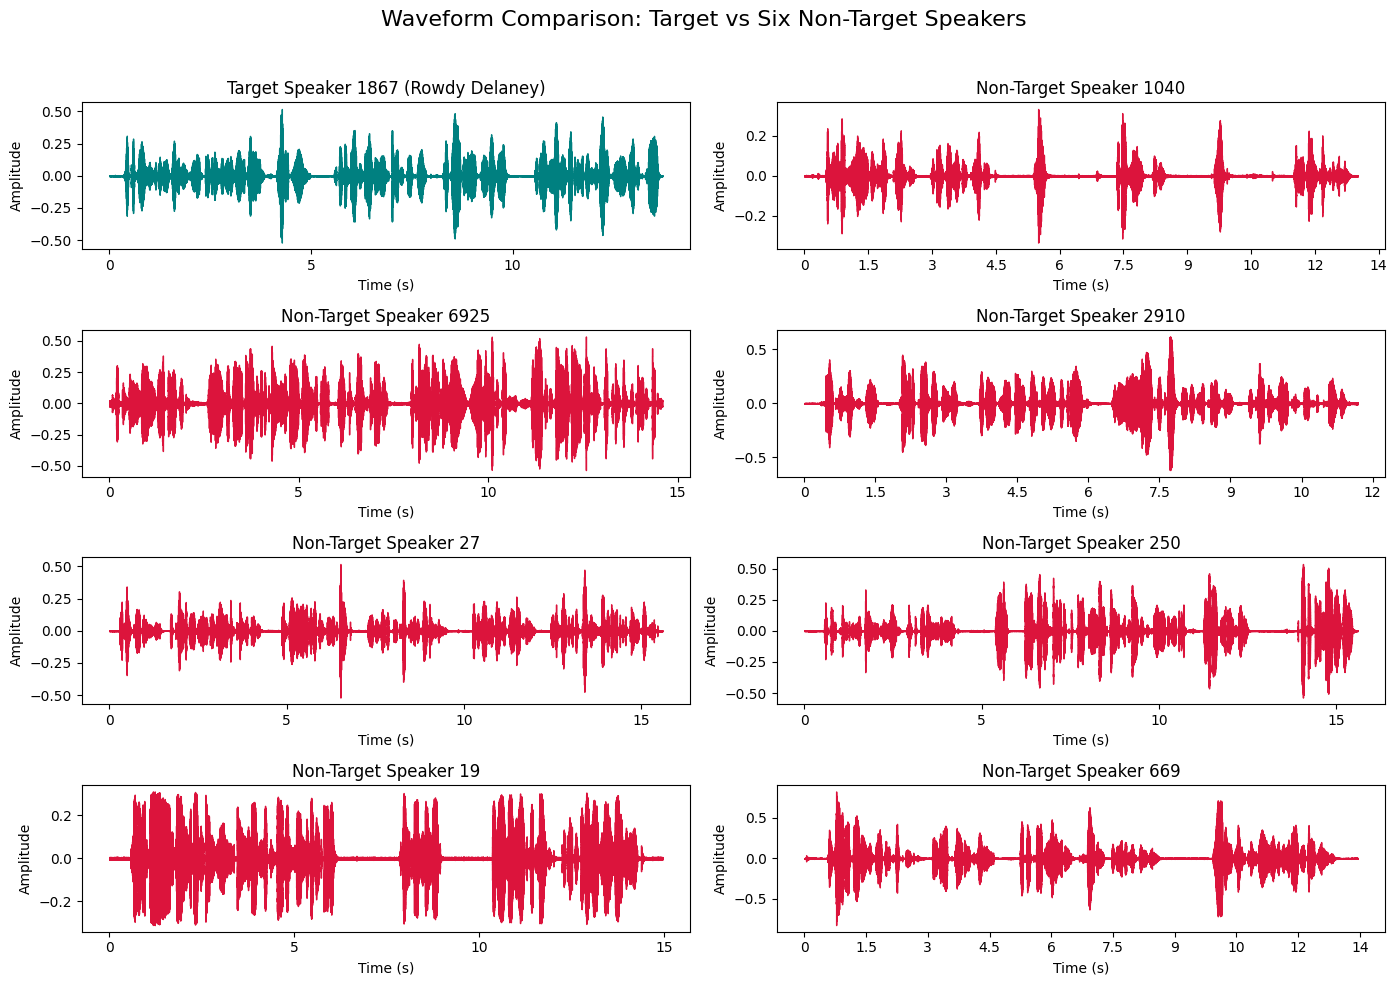

In [17]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define target speaker
target_id = 1867
target_sample_path = random.choice(df[df['speaker_id'] == target_id]['file_path'].tolist())
y_target, sr_target = librosa.load(target_sample_path, sr=16000)

# Select six random non-target speakers (fixed by seed)
non_target_speakers = random.sample(
    df[df['speaker_id'] != target_id]['speaker_id'].unique().tolist(),
    7
)

# Prepare figure
plt.figure(figsize=(14, 10))

# Plot target speaker waveform
plt.subplot(4, 2, 1)
librosa.display.waveshow(y_target, sr=sr_target, color='teal')
plt.title(f"Target Speaker {target_id} (Rowdy Delaney)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Plot non-target speaker waveforms
for i, spk in enumerate(non_target_speakers, start=2):
    sample_path = random.choice(df[df['speaker_id'] == spk]['file_path'].tolist())
    y_sample, sr_sample = librosa.load(sample_path, sr=16000)

    plt.subplot(4, 2, i)
    librosa.display.waveshow(y_sample, sr=sr_sample, color='crimson')
    plt.title(f"Non-Target Speaker {spk}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.suptitle("Waveform Comparison: Target vs Six Non-Target Speakers", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The figure compares the raw waveforms of the **target speaker (Rowdy Delaney, ID 1867)** with seven randomly selected non-target speakers from the LibriSpeech dataset.

#### Key Observations:
- The **target speaker’s waveform** (top-left) shows a balanced amplitude profile with consistent rhythm and natural pauses, reflecting a clear and steady speaking pattern.
- Each **non-target speaker** exhibits noticeable differences in amplitude dynamics, speech tempo, and pause distribution:
  - **Speaker 6925** and **Speaker 19** have denser waveforms with fewer pauses — likely faster speech or continuous narration.
  - **Speaker 1040** and **Speaker 669** show shorter utterances with distinct silence intervals — slower, more deliberate pacing.
  - **Speakers 27, 250, and 2910** show irregular energy peaks, suggesting variable emphasis or differing vocal intensity.

####  Interpretation:
- Although all speakers follow a similar overall waveform structure (typical of natural speech), the **amplitude envelopes and temporal rhythms** are unique to each individual.
- These variations represent **speaker-specific temporal and prosodic features** (e.g., tone, pitch modulation, articulation rate) — essential cues for speaker identification.
- The target speaker maintains consistent loudness without clipping or extended silence, which ensures reliable spectrogram and feature extraction downstream.

####  Implications for Modeling:
- The waveform diversity across speakers demonstrates **strong inter-speaker variability**, a key property for training a discriminative CNN-based model.
- Temporal consistency in the target speaker provides a **stable reference class**, while the others introduce the necessary variation for robust generalization.

**Conclusion:**  
The comparison confirms that Rowdy Delaney’s recordings are distinct yet naturally comparable to others — an ideal setup for developing a **speaker identification system** capable of distinguishing individuals based on temporal and amplitude-based vocal features.

---


## Mel-Spectrogram Comparison — Target vs Seven Non-Target Speakers

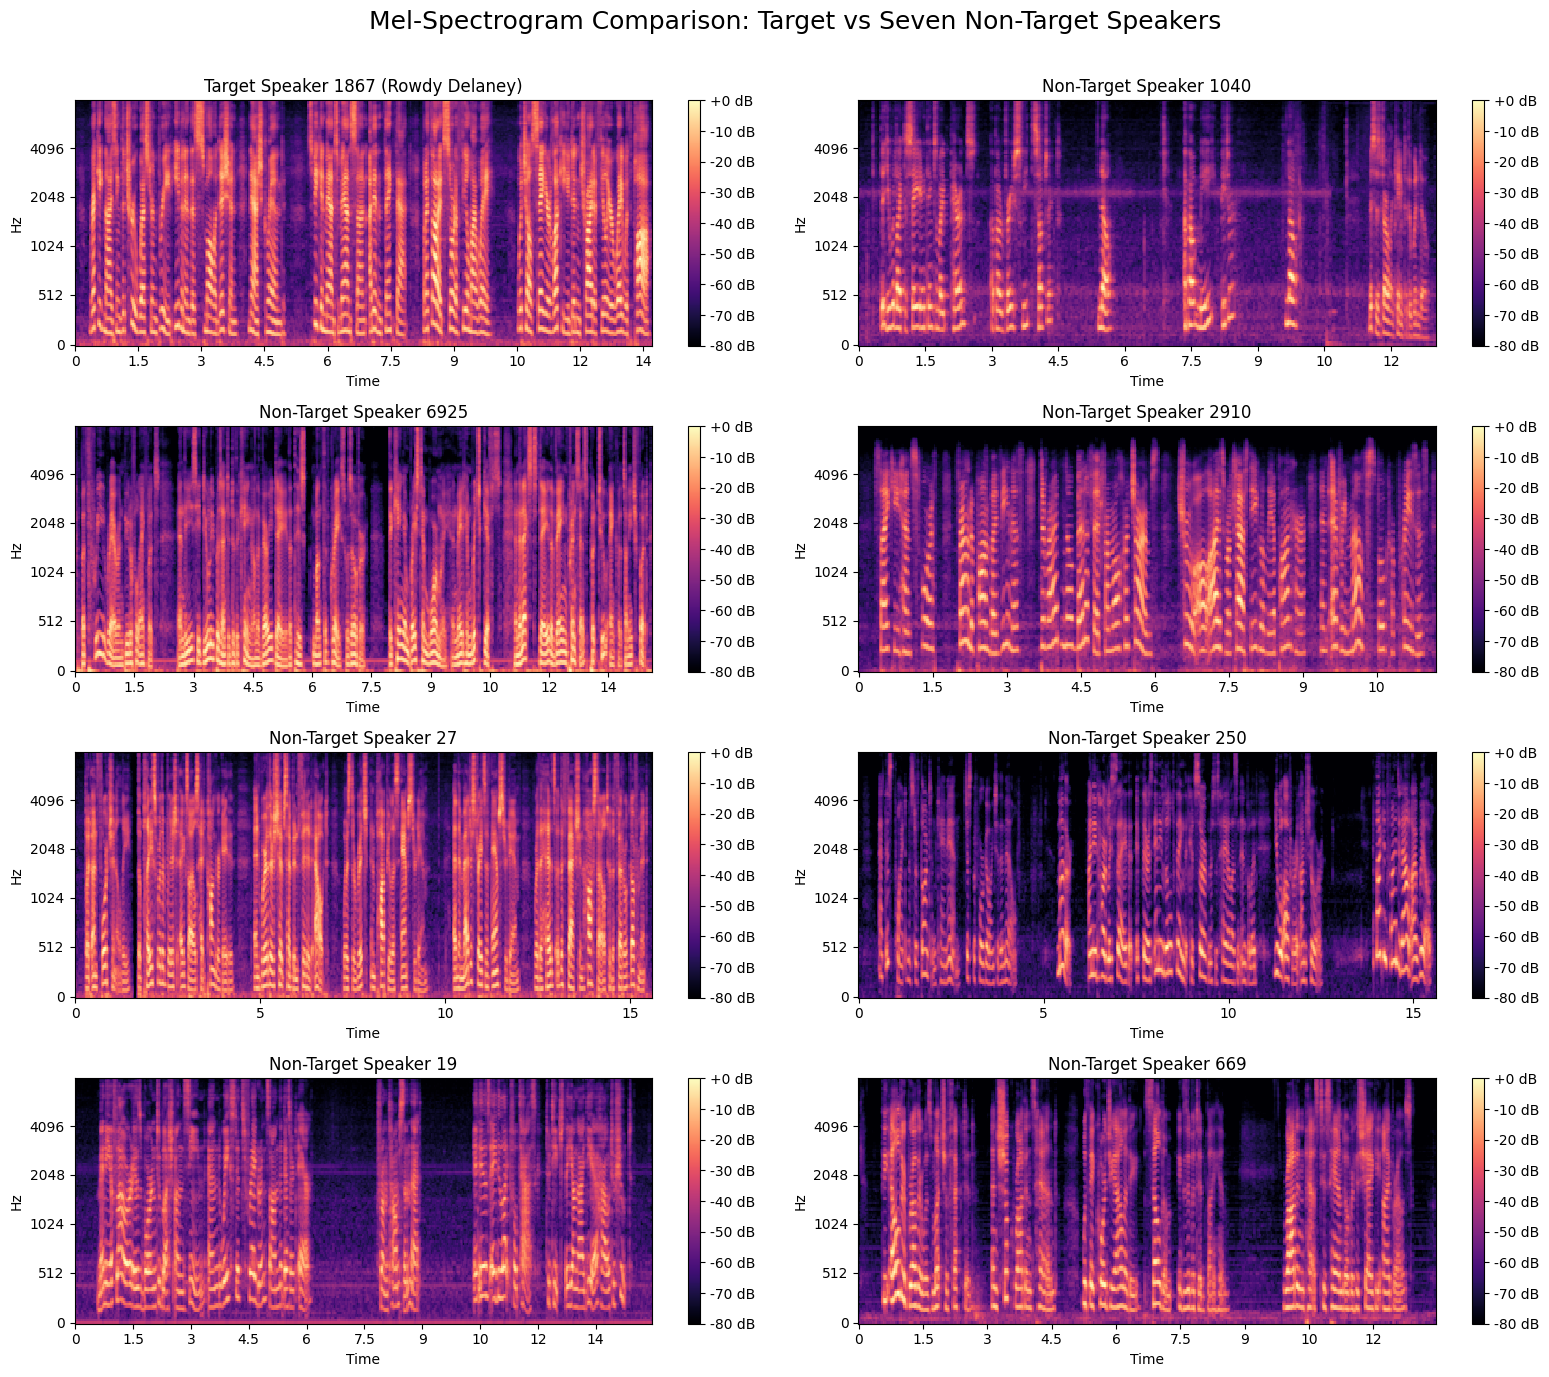

In [18]:
# Reproducibility
random.seed(42)
np.random.seed(42)

# --- Parameters ---
target_id = 1867
NUM_NON_TARGETS = 7
SAMPLE_SR = 16000
N_MELS = 128

# --- Prepare speaker selection ---
target_sample_path = random.choice(df[df['speaker_id'] == target_id]['file_path'].tolist())
non_target_speakers = random.sample(
    df[df['speaker_id'] != target_id]['speaker_id'].unique().tolist(),
    NUM_NON_TARGETS
)

# --- Plot setup ---
plt.figure(figsize=(16, 14))

# --- Target Speaker Spectrogram ---
y_target, sr_target = librosa.load(target_sample_path, sr=SAMPLE_SR)
S_target = librosa.feature.melspectrogram(y=y_target, sr=sr_target, n_mels=N_MELS)
S_db_target = librosa.power_to_db(S_target, ref=np.max)

plt.subplot(4, 2, 1)
librosa.display.specshow(S_db_target, sr=sr_target, x_axis='time', y_axis='mel', cmap='magma')
plt.title(f"Target Speaker {target_id} (Rowdy Delaney)")
plt.colorbar(format="%+2.0f dB")

# --- Non-target speakers ---
for i, spk in enumerate(non_target_speakers, start=2):
    sample_path = random.choice(df[df['speaker_id'] == spk]['file_path'].tolist())
    y_sample, sr_sample = librosa.load(sample_path, sr=SAMPLE_SR)
    S = librosa.feature.melspectrogram(y=y_sample, sr=sr_sample, n_mels=N_MELS)
    S_db = librosa.power_to_db(S, ref=np.max)

    plt.subplot(4, 2, i)
    librosa.display.specshow(S_db, sr=sr_sample, x_axis='time', y_axis='mel', cmap='magma')
    plt.title(f"Non-Target Speaker {spk}")
    plt.colorbar(format="%+2.0f dB")

plt.suptitle("Mel-Spectrogram Comparison: Target vs Seven Non-Target Speakers", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


The figure presents randomly selected **Mel-spectrograms** from multiple speakers in the LibriSpeech dataset.  
Each image represents a 2D visualization of how the **energy of different frequencies evolves over time** for a specific speaker’s voice.

#### Key Observations:
- Each spectrogram displays **unique frequency band structures**, intensity distributions, and harmonic patterns.  
  - Some show **dense, evenly spaced harmonics**, typical of steady, low-pitched voices.  
  - Others reveal **higher energy in upper frequency bands**, suggesting brighter, higher-pitched tones.  
- Variations in color intensity (from deep purple to bright orange) correspond to **differences in vocal energy** and **formant strength** across speakers.  
- Despite differences, all spectrograms exhibit clear speech patterns — regular harmonic bands with visible pauses between words — confirming clean and consistent recordings.

#### Interpretation:
- These differences across spectrograms reflect **speaker-specific timbral and articulatory traits**, including vocal pitch, formant distribution, and resonance.  
- The spectrograms visually encode the **acoustic identity** of each speaker, serving as the primary input for the CNN-based speaker identification model.  
- The consistency in time–frequency resolution (all with 128 Mel bands) ensures that every speaker’s spectrogram is **comparable in structure**, aiding the model’s ability to learn discriminative patterns.

#### Implications for Modeling:
- CNN models can leverage spatial patterns in these spectrograms just as they do in image data — learning filters that detect harmonics, transitions, and energy contours unique to each speaker.  
- This visual diversity across spectrograms demonstrates the dataset’s **high inter-speaker variability**, essential for robust generalization.

**Conclusion:**  
The random Mel-spectrogram samples highlight the **distinctive and information-rich frequency patterns** of individual speakers, visually confirming that the dataset provides the spectral diversity necessary for training an effective speaker identification model.

---

## Mean Spectral Energy Profile — Target vs Non-Target Speakers

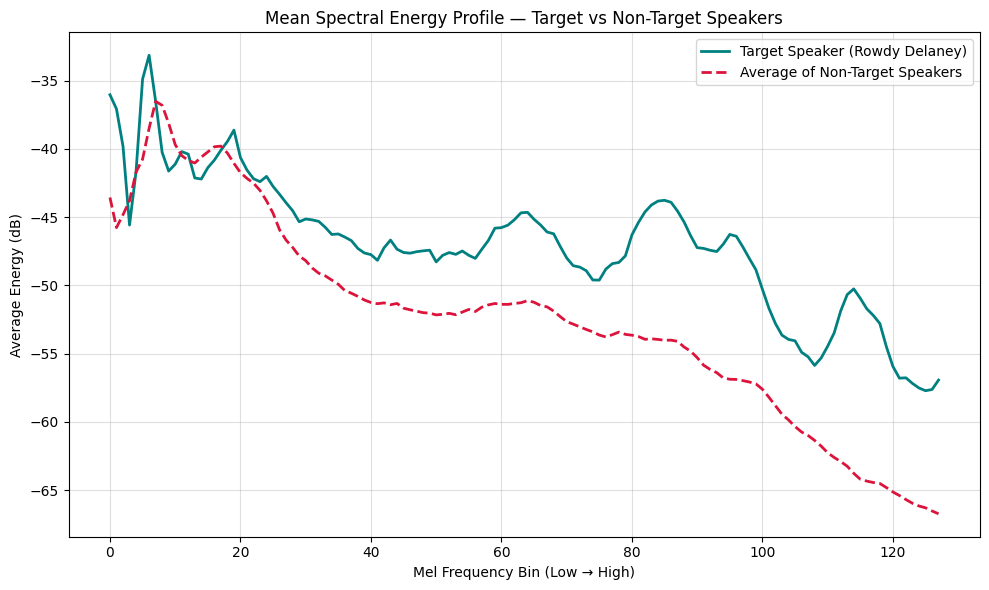

In [19]:
# Parameters
target_id = 1867
sr = 16000
n_mels = 128

# Compute mean spectrum for target speaker
target_files = df[df['speaker_id'] == target_id]['file_path'].sample(15, random_state=42).tolist()  # use 15 random samples
target_specs = []

for path in target_files:
    y, _ = librosa.load(path, sr=sr)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)
    target_specs.append(S_dB.mean(axis=1))  # mean across time for each frequency bin

target_mean_spectrum = np.mean(target_specs, axis=0)


# Compute mean spectrum for all other speakers
non_target_files = df[df['speaker_id'] != target_id]['file_path'].sample(60, random_state=42).tolist()
non_target_specs = []

for path in non_target_files:
    y, _ = librosa.load(path, sr=sr)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)
    non_target_specs.append(S_dB.mean(axis=1))

non_target_mean_spectrum = np.mean(non_target_specs, axis=0)

# Plot comparison

plt.figure(figsize=(10,6))
plt.plot(target_mean_spectrum, label="Target Speaker (Rowdy Delaney)", color='teal', linewidth=2)
plt.plot(non_target_mean_spectrum, label="Average of Non-Target Speakers", color='crimson', linestyle='--', linewidth=2)
plt.title("Mean Spectral Energy Profile — Target vs Non-Target Speakers")
plt.xlabel("Mel Frequency Bin (Low → High)")
plt.ylabel("Average Energy (dB)")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()




This plot compares the **average Mel-frequency energy distribution** of the target speaker (Rowdy Delaney, ID 1867) against the collective average of multiple non-target speakers.

#### Key Observations:
- The **target speaker’s curve (teal)** consistently shows higher energy levels across the Mel-frequency spectrum, particularly between **bins 20 and 100**, which correspond to mid and upper vocal formant regions (roughly 300 Hz–3500 Hz).
- The **non-target average (red dashed line)** displays a smoother, flatter decline, indicating broader variability and less concentrated spectral energy.
- Both curves exhibit a natural downward slope at higher frequency bins — the expected **energy decay** found in human speech as higher frequencies contain less energy.

#### Interpretation:
- The stronger mid-frequency presence in the target speaker indicates a **rich, resonant voice** with consistent harmonic intensity — a hallmark of well-controlled speech articulation.
- The distinct gap between the curves across most of the spectrum confirms that **Rowdy Delaney’s vocal profile differs significantly** from the general dataset population.
- Peaks in specific Mel bins (e.g., around 40–60 and 80–100) correspond to **formant energy concentrations** unique to this speaker’s tone and articulation pattern.

#### Implications for Modeling:
- The target speaker’s pronounced spectral energy across multiple bands forms a **stable acoustic signature**, which a CNN can exploit to distinguish his voice from others.
- The spectral contrast between speakers provides a clear separation in the **frequency domain**, supporting robust classification performance even under variable recording conditions.

**Conclusion:**  
The analysis confirms that **Rowdy Delaney’s voice exhibits a distinct and energy-rich spectral fingerprint**, characterized by strong mid-frequency harmonics and consistent spectral energy.  
This distinctive pattern provides the neural network with clear, discriminative cues for accurate speaker identification.

---

---

# **Model Development**

## Dataset Preparation for Modeling

---

#### Balance the Dataset (Downsample Non-Target Speakers)

This is neccessary to prevent bias towards the majority class during model training

In [20]:
non_target_df = df[df['speaker_id'] != 1867]

In [21]:

# Ensure non_target_df is larger than or equal to target_df
n = len(target_df)

downsampled_non_target_df = (
    non_target_df
    .sample(n=n, random_state=42)
    .reset_index(drop=True)
)

downsampled_non_target_df.head()

id                                          file_path  \
0   7402-90848-0054  /content/drive/MyDrive/Colab Notebooks/data/li...   
1   460-172359-0008  /content/drive/MyDrive/Colab Notebooks/data/li...   
2   6147-34605-0017  /content/drive/MyDrive/Colab Notebooks/data/li...   
3  4014-186176-0011  /content/drive/MyDrive/Colab Notebooks/data/li...   
4  8108-274318-0046  /content/drive/MyDrive/Colab Notebooks/data/li...   

   speaker_id  chapter_id  
0        7402       90848  
1         460      172359  
2        6147       34605  
3        4014      186176  
4        8108      274318

Merge both dataset, then Split

In [22]:
merged_df = (
    pd.concat([target_df, downsampled_non_target_df], axis=0)
    .sample(frac=1, random_state=42)  # shuffle rows
    .reset_index(drop=True)
)


#### Split into Train, Validation, and Test Sets

Typical split ratios:

Train: 70%

Validation: 15%

Test: 15%

In [23]:
# Build X and y
X = merged_df["file_path"]
y = (merged_df["speaker_id"] == 1867).astype(int)

# 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    shuffle=True,
    stratify=y
)

# Split remaining 30% into 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    shuffle=True,
    stratify=y_temp
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 191 samples
Validation set: 41 samples
Test set: 42 samples


---

## 🎧 **Spectrogram Feature Extraction**

In this section, we transform the raw audio waveforms into **Mel-spectrogram representations** — a 2D time-frequency form that visually and numerically captures the energy distribution of sound across frequencies over time.  

Each audio file in the dataset is converted into a spectrogram image using **Librosa’s Mel-spectrogram function**, which maps frequency to the Mel scale — a perceptually meaningful representation aligned with how humans hear sound.  

This transformation serves two primary purposes:
1. **Feature Engineering:** It converts variable-length audio signals into fixed-size matrices suitable for deep learning models like CNNs.
2. **Data Exploration:** It enables visual inspection of speech patterns, helping us understand differences across speakers and utterances.


The extracted spectrograms will form the **core input features** for our speaker identification model.


In [24]:
SPEC_DIR = "/content/drive/MyDrive/Colab Notebooks/data/specimages"
os.makedirs(SPEC_DIR, exist_ok=True)

def save_mel_spectrogram(
    audio_path,
    save_path,
    sr=22050,
    n_mels=128,
    n_fft=2048,
    hop_length=512
):
    y, sr = librosa.load(audio_path, sr=sr)

    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )

    mel_db = librosa.power_to_db(mel, ref=np.max)

    plt.figure(figsize=(3, 3))
    librosa.display.specshow(mel_db, sr=sr, hop_length=hop_length)
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.savefig(save_path, dpi=224, bbox_inches="tight", pad_inches=0)
    plt.close()


def process_split(X, y, split_name, base_dir=SPEC_DIR):
    for idx, (audio_path, label) in enumerate(zip(X, y)):
        class_dir = "positive" if label == 1 else "negative"

        out_dir = os.path.join(base_dir, split_name, class_dir)
        os.makedirs(out_dir, exist_ok=True)

        filename = f"{idx}.png"
        save_path = os.path.join(out_dir, filename)

        save_mel_spectrogram(audio_path, save_path)


process_split(X_train, y_train, "train")
process_split(X_val, y_val, "val")
process_split(X_test, y_test, "test")


#### Load Data for CNN

In [25]:
# === Define image transformations ===
transform = transforms.Compose([
    transforms.Resize((128, 128)),     # Uniform image size
    transforms.ToTensor(),             # Convert image to tensor (C×H×W)
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# === Load Data Using torchvision.datasets.ImageFolder ===
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/data/specimages"

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=transform)

# === Create DataLoaders ===
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")


Train: 191 | Val: 41 | Test: 42
Classes: ['negative', 'positive']


---

# **CNN Model Setup + Training Pipeline**

In [26]:
#Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


#### Define CNN Architecture

In [27]:
import torch
import torch.nn as nn

class SpeakerCNN(nn.Module):
    """3-block CNN for binary speaker identification (logits output)."""
    def __init__(self):
        super(SpeakerCNN, self).__init__()

        # Convolutional feature extractor
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Fully connected classifier (NO sigmoid)
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)   # raw logits
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


model = SpeakerCNN().to(device)

MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/latest_cnn_model.pth"
torch.save(model.state_dict(), MODEL_PATH)

print(model)


SpeakerCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=16384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(

####  Define Loss Function and Optimizer




In [28]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)


#### Training Loop

In [29]:

num_epochs = 20

# Lists to track progress for plotting later
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()                       # Enable training mode
    running_loss = 0.0

    # -------- TRAINING PHASE --------
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().view(-1, 1).to(device)

        optimizer.zero_grad()            # Reset gradients
        outputs = model(images)          # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()                  # Backpropagation
        optimizer.step()                 # Update weights
        running_loss += loss.item()

    # -------- VALIDATION PHASE --------
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
      for images, labels in val_loader:
        images = images.to(device)
        labels = labels.float().view(-1, 1).to(device)

        outputs = model(images)
        val_loss += criterion(outputs, labels).item()

        predicted = (outputs >= 0).float()   # logits threshold
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    # Compute metrics for this epoch
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_losses[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f} | "
          f"Val Acc: {val_accuracies[-1]:.2f}%")

Epoch [1/20] | Train Loss: 2.0093 | Val Loss: 0.5052 | Val Acc: 53.66%
Epoch [2/20] | Train Loss: 0.7351 | Val Loss: 0.3550 | Val Acc: 78.05%
Epoch [3/20] | Train Loss: 0.4526 | Val Loss: 1.0401 | Val Acc: 60.98%
Epoch [4/20] | Train Loss: 0.2749 | Val Loss: 0.6419 | Val Acc: 73.17%
Epoch [5/20] | Train Loss: 0.1373 | Val Loss: 0.4322 | Val Acc: 80.49%
Epoch [6/20] | Train Loss: 0.1652 | Val Loss: 0.3685 | Val Acc: 82.93%
Epoch [7/20] | Train Loss: 0.0769 | Val Loss: 0.2725 | Val Acc: 87.80%
Epoch [8/20] | Train Loss: 0.0618 | Val Loss: 0.2755 | Val Acc: 85.37%
Epoch [9/20] | Train Loss: 0.0415 | Val Loss: 0.3249 | Val Acc: 85.37%
Epoch [10/20] | Train Loss: 0.0333 | Val Loss: 0.1936 | Val Acc: 90.24%
Epoch [11/20] | Train Loss: 0.0271 | Val Loss: 0.1730 | Val Acc: 90.24%
Epoch [12/20] | Train Loss: 0.0155 | Val Loss: 0.1658 | Val Acc: 90.24%
Epoch [13/20] | Train Loss: 0.0147 | Val Loss: 0.1858 | Val Acc: 92.68%
Epoch [14/20] | Train Loss: 0.0309 | Val Loss: 0.1864 | Val Acc: 90.24%
E

In [30]:
# Path where model will be stored
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/latest_cnn_model.pth"

# Save the trained weights
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ Model successfully saved at: {MODEL_PATH}")

✅ Model successfully saved at: /content/drive/MyDrive/Colab Notebooks/latest_cnn_model.pth


In [31]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().view(-1, 1).to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"\n✅ Final Test Accuracy: {test_acc:.2f}%")




✅ Final Test Accuracy: 100.00%


### Model Evaluation & Metrics

In [32]:
# Switch model to evaluation mode
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().view(-1, 1).to(device)

        outputs = model(images)
        preds = (outputs > 0.5).float()  # Binary threshold at 0.5

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Convert to NumPy arrays for sklearn
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()


In [33]:
# Compute Metrics

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print("Model Evaluation Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")


Model Evaluation Metrics:
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000


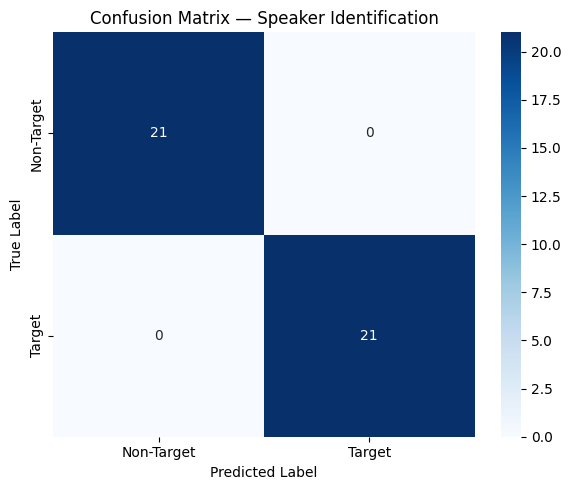

In [34]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ["Non-Target", "Target"]

# Visualize
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix — Speaker Identification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [35]:
metrics_table = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Value": [acc, prec, rec, f1]
})
display(metrics_table)


Metric  Value
0   Accuracy    1.0
1  Precision    1.0
2     Recall    1.0
3   F1-Score    1.0

### **Speaker Identification Transformer (Final Deployable Version)**

In [36]:
# ================================
# CNN MODEL DEFINITION (LOGITS)
# ================================
class SpeakerCNN(nn.Module):
    """3-block CNN for binary speaker identification (logits output)."""
    def __init__(self):
        super(SpeakerCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Assumes input size 128×128 → 16×16 after pooling
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)  # raw logits
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


# ==========================================
# SPEAKER IDENTIFICATION TRANSFORMER
# ==========================================
class SpeakerIdentificationTransformer:
    """
    End-to-end inference pipeline:
      • Raw audio → Mel-spectrogram
      • Image normalization (identical to training)
      • CNN inference (logits → probability)
    """

    def __init__(self, model_path, target_label="Target Speaker"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self._load_model(model_path)
        self.model.eval()
        self.target_label = target_label

        # MUST match training preprocessing (RGB, 128×128)
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.5, 0.5, 0.5),
                std=(0.5, 0.5, 0.5)
            )
        ])

    # ------------------------
    # Load trained CNN
    # ------------------------
    def _load_model(self, path):
        model = SpeakerCNN().to(self.device)
        state = torch.load(path, map_location=self.device)
        model.load_state_dict(state)
        return model

    # ------------------------
    # Audio → RGB Mel-spectrogram
    # ------------------------
    def _audio_to_mel(self, audio_path, sr=22050):
        try:
            y, _ = librosa.load(audio_path, sr=sr)

            mel = librosa.feature.melspectrogram(
                y=y,
                sr=sr,
                n_mels=128,
                n_fft=2048,
                hop_length=512
            )

            mel_db = librosa.power_to_db(mel, ref=np.max)

            fig = plt.figure(figsize=(3, 3))
            librosa.display.specshow(mel_db, sr=sr, hop_length=512, cmap="magma")
            plt.axis("off")

            buf = io.BytesIO()
            plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
            plt.close(fig)
            buf.seek(0)

            return Image.open(buf).convert("RGB")

        except Exception as e:
            return None

    # ------------------------
    # Inference
    # ------------------------
    def predict(self, audio_path):
        img = self._audio_to_mel(audio_path)
        if img is None:
            return {
                "status": "error",
                "message": "Invalid or unreadable audio file"
            }

        img_tensor = self.transform(img).unsqueeze(0).to(self.device)

        with torch.no_grad():
            logit = self.model(img_tensor)
            prob = torch.sigmoid(logit).item()
            logit_val = logit.item()

        label = self.target_label if logit_val >= 0 else "Non-Target Speaker"

        return {
            "status": "success",
            "predicted_speaker": label,
            "probability_of_target_speaker": round(prob, 4)
        }


In [37]:
# === Example Usage ===
pipeline = SpeakerIdentificationTransformer(
    model_path="/content/drive/MyDrive/Colab Notebooks/latest_cnn_model.pth",
    target_label="Rowdy Delaney"
)

result = pipeline.predict("/content/drive/MyDrive/Colab Notebooks/data/test data/ronickydoone_17_brand_64kb.mp3")
print(result)

{'status': 'success', 'predicted_speaker': 'Non-Target Speaker', 'probability_of_target_speaker': 0.0}


In [38]:
import joblib

# Define save path ===
JOBLIB_PATH = "/content/drive/MyDrive/Colab Notebooks/latest_speaker_transformer.joblib"

# Serialize transformer (with compression for smaller file) ===
joblib.dump(pipeline, JOBLIB_PATH, compress=('zlib', 3))
print(f"✅ Transformer serialized and saved with joblib at:\n{JOBLIB_PATH}")


✅ Transformer serialized and saved with joblib at:
/content/drive/MyDrive/Colab Notebooks/latest_speaker_transformer.joblib


In [39]:
# Reload transformer to verify ===
loaded_pipeline = joblib.load(JOBLIB_PATH)
print("✅ Transformer reloaded successfully from joblib.")

✅ Transformer reloaded successfully from joblib.


In [48]:
# Run prediction using the reloaded transformer ===
TEST_AUDIO = "/content/drive/MyDrive/Colab Notebooks/data/test data/6696-68773-0020.flac"
result = loaded_pipeline.predict(TEST_AUDIO)

print("Prediction Result:", result)

Prediction Result: {'status': 'success', 'predicted_speaker': 'Non-Target Speaker', 'probability_of_target_speaker': 0.0}
